![](aux/titlepage.png)

# Part 1: Bayesian Modelling with Turing.jl

![](aux/turing.png)

## Simple example to get started: Coin toss

This example is taken from the `Turing.jl` [documentation pages](https://turing.ml/v0.22/docs/using-turing/quick-start).

First of all, we have to install the `Turing.jl` package. Actually, it's good practice to first create an environment where all the package versions for our specific current project are specified. This helps with reproducibility and makes sure that we don't run into version conflicts when re-running the code later. If an environment is activated, all package dependencies are automatically saved in a `Project.toml` file (containing only the explicitly installed packages) and a `Manifest.toml` file (containing also all dependencies of the installed packages). The `Project.toml` file can be used to recreate the environment on another machine, using the `Pkg.instantiate()` command.

In [2]:
using Pkg
Pkg.activate("aux/") # creates a new enviroment in the source directory
Pkg.add("Turing") # installs the Turing package
Pkg.status() # prints out all the packages in the enviroment in their respective versions

  Activating project at `~/UiO/Docs/Meetings/public-slides/Presentations/aux`


   Resolving package versions...


  No Changes to `~/UiO/Docs/Meetings/public-slides/Presentations/aux/Project.toml`
  No Changes to `~/UiO/Docs/Meetings/public-slides/Presentations/aux/Manifest.toml`


Status `~/UiO/Docs/Meetings/public-slides/Presentations/aux/Project.toml`
  [336ed68f] CSV v0.10.11
⌃ [a93c6f00] DataFrames v1.3.6
  [31c24e10] Distributions v0.25.96
  [38e38edf] GLM v1.8.3
  [91a5bcdd] Plots v1.38.16
  [92933f4c] ProgressMeter v1.7.2
  [2913bbd2] StatsBase v0.34.0
  [f3b207a7] StatsPlots v0.15.5
⌃ [fce5fe82] Turing v0.26.1
  [112f6efa] VegaLite v3.2.2
  [e88e6eb3] Zygote v0.6.62
Info Packages marked with ⌃ have new versions available and may be upgradable.


To actually use the functionality in the package, we have to import it. We can do this with the `using` keyword (similar to `import` in Python or `library()` in R). This means that the package will be pre-compiled and all exported functions will be available in the current namespace. 

Additionally, we will need some other packages: 
 -  the `Distributions` package for the probability distributions, 
 -  the `Plots`, `StatsPlots`  and `VegaLite` packages for plotting, 
 -  the `CSV` and `DataFrames` packages for working with a real data set

In [3]:
Pkg.add(["Distributions", "Plots", "StatsPlots", "VegaLite", "CSV", "DataFrames"])
Pkg.status()

using CSV
using DataFrames
using Distributions
using Turing
using Random
using Plots
using StatsPlots
using VegaLite

   Resolving package versions...


  No Changes to `~/UiO/Docs/Meetings/public-slides/Presentations/aux/Project.toml`
  No Changes to `~/UiO/Docs/Meetings/public-slides/Presentations/aux/Manifest.toml`


Status `~/UiO/Docs/Meetings/public-slides/Presentations/aux/Project.toml`
  [336ed68f] CSV v0.10.11
⌃ [a93c6f00] DataFrames v1.3.6
  [31c24e10] Distributions v0.25.96
  [38e38edf] GLM v1.8.3
  [91a5bcdd] Plots v1.38.16
  [92933f4c] ProgressMeter v1.7.2
  [2913bbd2] StatsBase v0.34.0
  [f3b207a7] StatsPlots v0.15.5
⌃ [fce5fe82] Turing v0.26.1
  [112f6efa] VegaLite v3.2.2
  [e88e6eb3] Zygote v0.6.62
Info Packages marked with ⌃ have new versions available and may be upgradable.


Now, we can define our coin toss model. We use a $\mathrm{Beta}(1,1)$ prior for the probability of heads. 

We can either use $n$ samples from a Bernoulli distribution with probability $p$ or a Binomial distribution with $n$ trials and probability $p$, where $n$ is the number of coin tosses and $p$ is the probability of heads. 

The model is defined using the `@model` macro, which takes a function as an argument, containing the model definition. The `@model` macro creates a `TuringModel` object, which can be used to sample from the posterior distribution.

In [4]:
@model function coin_toss(y)
    p ~ Beta(1,1)
    for i in length(y)
        #yᵢ ~ Bernoulli(p)
        y[i] ~ Bernoulli(p)
    end
end

coin_toss (generic function with 2 methods)

Let's create some data and run a sampler to get samples from the posterior distribution.

In [5]:
# generate some data
p = 0.5
Random.seed!(27) # for reproducibility
data = rand(Bernoulli(p), 100) 
@info sum(data)

# start sampling
chain_coin_toss = sample(coin_toss(data), NUTS(), 1000, progress=false)

┌ Info: 55
└ @ Main /home/waldir/UiO/Docs/Meetings/public-slides/Presentations/20230622-BayesianModellingWithTuring.ipynb:5
┌ Info: Found initial step size
│   ϵ = 3.2
└ @ Turing.Inference /home/waldir/.julia/packages/Turing/zrPsf/src/inference/hmc.jl:204


Chains MCMC chain (1000×13×1 Array{Float64, 3}):

Iterations        = 501:1:1500
Number of chains  = 1
Samples per chain = 1000
Wall duration     = 5.72 seconds
Compute duration  = 5.72 seconds
parameters        = p
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std      mcse   ess_bulk   ess_tail      rhat   e ⋯
      Symbol   Float64   Float64   Float64    Float64    Float64   Float64     ⋯

           p    0.6669    0.2281    0.0107   430.8498   499.0536    1.0020     ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

           p    0.1789    0.5035    0.6991    0.8561    0.9848


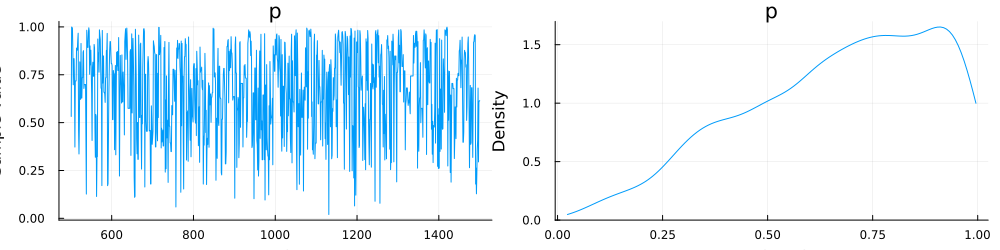

In [6]:
# plot a summary of the sampling process for the parameter p
plot(chain_coin_toss)

## More realistic example: Modelling drug response

The example implements a part of the model from the `bayesynergy` [package](https://github.com/ocbe-uio/bayesynergy) and [paper](https://academic.oup.com/bib/article/22/6/bbab251/6326504). 

There, drug response as measured by cell viability after treatment of a cell line with a single drug is modelled as a log-logistic function fitted to the concentration–response curve, 

$$
h(x \mid l, s, m) = l + \frac{(1−l)}{1+10^{s(x−m)}}, \quad x \in \mathbb{R}, 
$$

where $x$ denotes the $\log_{10}$ drug concentration, $l$ is the lower asymptote, $s$ is the slope and $m$ is the inflection point of the curve, corresponding the the $\log_{10}$ drug concentration needed to induce $50\%$ of the maximum response, which is referred to as the 'half-maximal effective concentration' or $EC_{50}$.

The main point of the paper is to develop a model for the interaction effect of two drugs that correctly accounts for all involved uncertainties and estimates the drug-response surface for pairwise combinations of two drugs. Here, we will only consider the simpler case of a model for a single drug (called the 'monotherapy model' in the paper).

The model is defined as follows:

$
\begin{align}
s &\sim \mathrm{Gamma}(1,1) \\
\theta  &\sim \mathrm{Normal}(0,1) \\
\sigma_m^2 &\sim \mathrm{InverseGamma}(3,2) \\
m &\sim \mathrm{Normal}(\theta,\sigma_m^2) \\
l &\sim \mathrm{Beta}(1,1.25) \\
\lambda &= 0.005 \\
\sigma &\sim \mathrm{InverseGamma}(5,1) \\
y_i &\sim \mathrm{Normal}(h(x_i \mid l, s, m), \sigma(h(x_i \mid l, s, m))+ \lambda), \quad i = 1, \dots, n \\
\end{align}
$

where $y_i$ is the measured response at concentration $x_i$ and $n$ is the number of data points.

This can be written in `Turing.jl` as follows:

In [7]:
h(x, l, s, m) = l + (1 - l) / (1 + 10^(s *(x - m)))

@model function fit_mono(x, y)

    # priors for log-logistic function parameters
    # slope (s) 
    s ~ Gamma(1,1)
    # EC50 (m)
    θ ~ Normal(0,1)
    σ_m_2 ~ InverseGamma(3,2)
    m ~ Normal(θ, sqrt(σ_m_2))
    # lower asymptote (l)
    l ~ Beta(1,1.25)

    # observation model 
    λ = 0.005 
    σ ~ InverseGamma(5,1)
    for i in 1:length(y)
        y[i] ~ Normal(h(x[i], l, s, m), sqrt(σ^2 * (h(x[i], l, s, m) + λ)))
    end
end

fit_mono (generic function with 2 methods)

Read in data from a CSV file. This is the viability measurements from a specific drug, Doxorubicin, screened on 39 cancer cell lines, in between 4 and 6 replicates. For the complete dataset and corresponding paper, see [ONeil et al. 2016](https://pubmed.ncbi.nlm.nih.gov/26983881/).

In [8]:
df = CSV.read("aux/monotherapy_Doxorubicin.csv", DataFrame)
first(df, 10)

10×3 DataFrame
 Row │ cellline  concentration  viability 
     │ String15  Float64        Float64   
─────┼────────────────────────────────────
   1 │ A2058         -3.85387       0.98
   2 │ A2058         -3.39794       0.09
   3 │ A2058         -2.92082       0.933
   4 │ A2058         -2.4318        0.704
   5 │ A2058         -1.95861       0.202
   6 │ A2058         -1.46852       0.176
   7 │ A2058         -1.0           0.055
   8 │ A2058         -0.522879      0.018
   9 │ A2058         -3.85387       1.103
  10 │ A2058         -3.39794       0.219

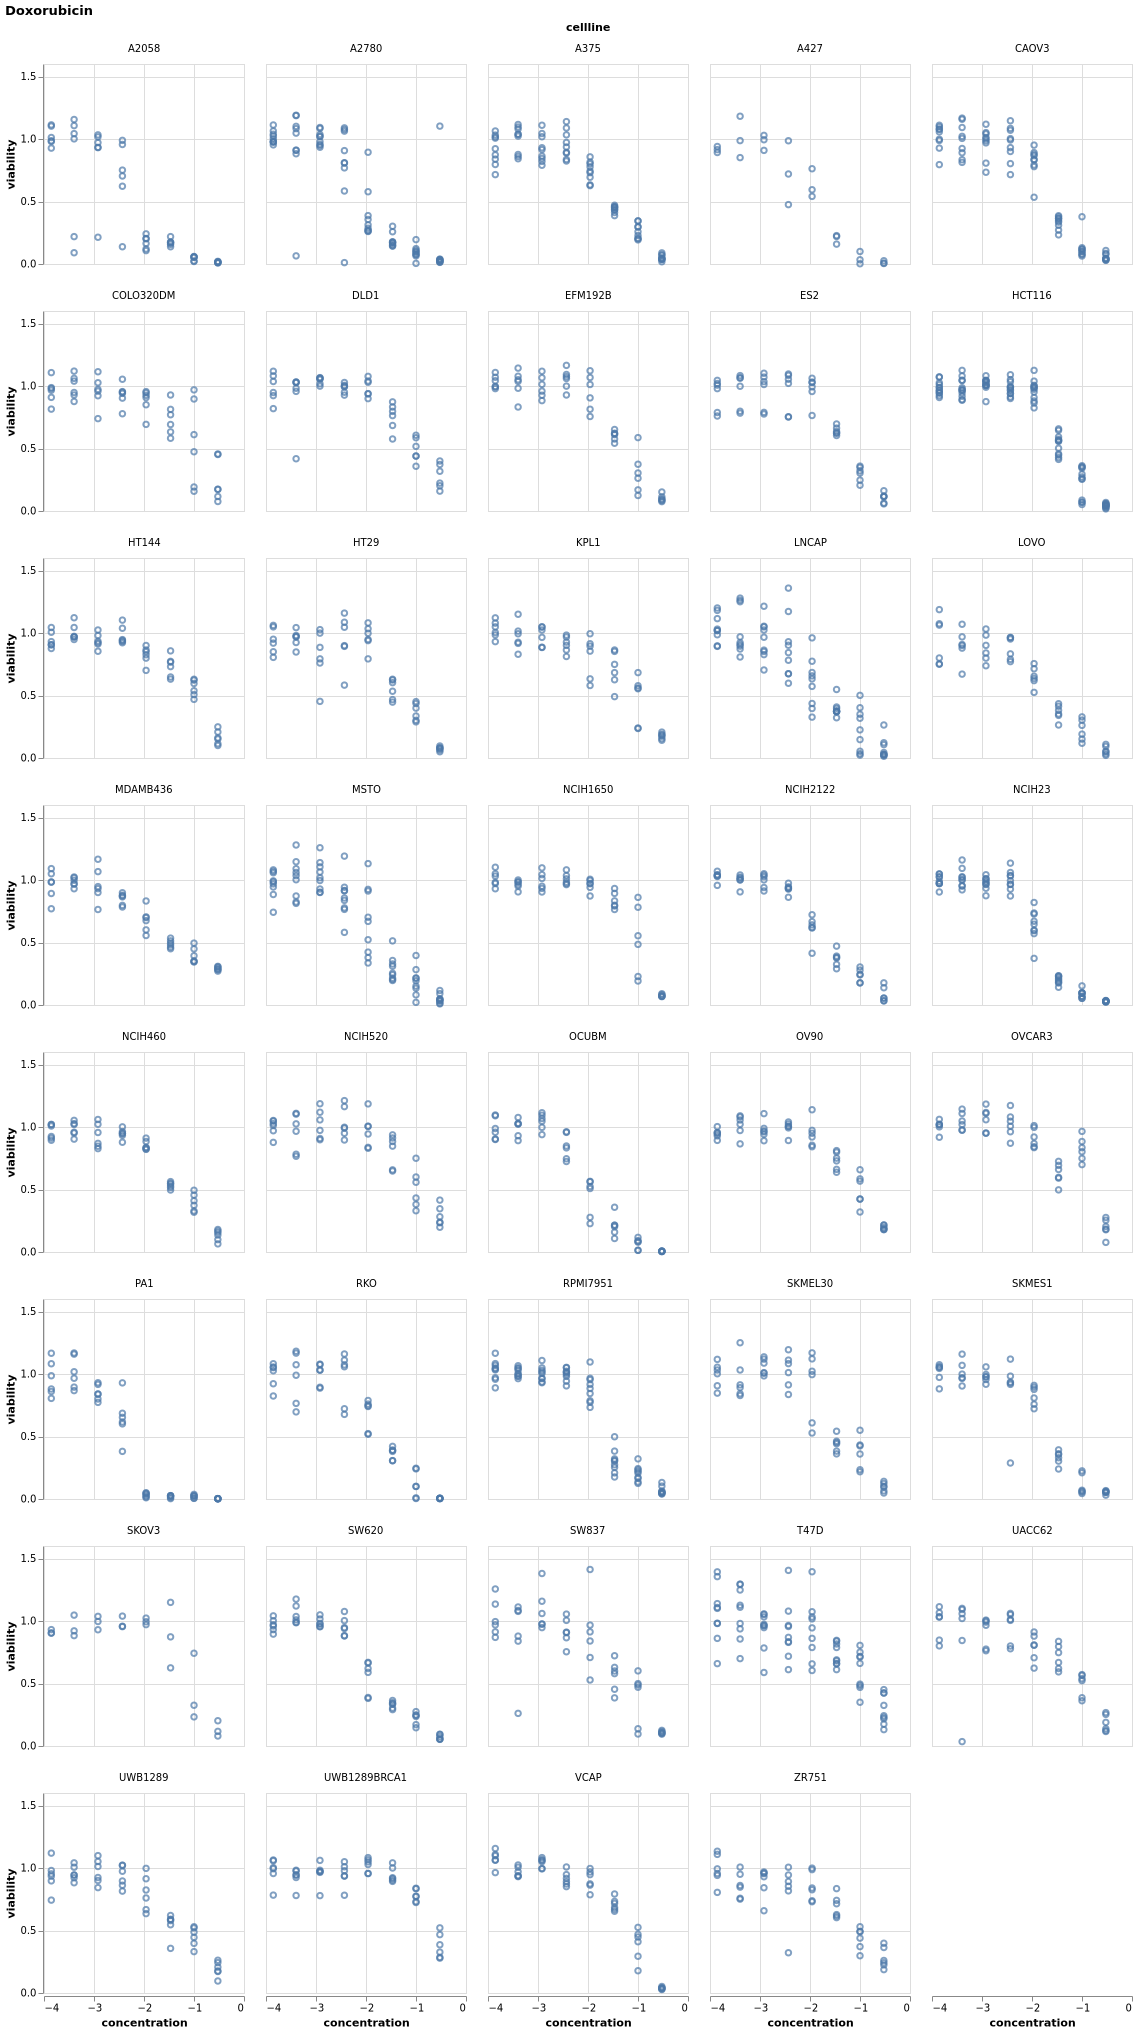

In [9]:
df |> @vlplot(:point, 
    x = :concentration, 
    y = :viability, 
    wrap = :cellline, 
    columns = 5, 
    title = "Doxorubicin"
)

Now, let's look at a specific cell line and extract the data:

In [10]:
cellline = "NCIH2122"
curdf = filter(row -> row[:cellline] == cellline, df)
xs = curdf[:,2]
ys = curdf[:,3]

48-element Vector{Float64}:
 1.033
 1.0
 1.05
 0.933
 0.722
 0.381
 0.304
 0.055
 1.039
 0.905
 ⋮
 0.138
 1.028
 1.04
 1.001
 0.927
 0.667
 0.325
 0.177
 0.177

We can now fit the monotherapy model to our data, using the `NUTS()` MCMC sampler. 

In [11]:
# fit model
Random.seed!(11) #11
chain_mono = sample(fit_mono(xs, ys), NUTS(), 1000, progress=false, verbose=false)

┌ Info: Found initial step size
│   ϵ = 0.05
└ @ Turing.Inference /home/waldir/.julia/packages/Turing/zrPsf/src/inference/hmc.jl:204


Chains MCMC chain (1000×18×1 Array{Float64, 3}):

Iterations        = 501:1:1500
Number of chains  = 1
Samples per chain = 1000
Wall duration     = 10.07 seconds
Compute duration  = 10.07 seconds
parameters        = s, θ, σ_m_2, m, l, σ
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std      mcse   ess_bulk   ess_tail      rhat   e ⋯
      Symbol   Float64   Float64   Float64    Float64    Float64   Float64     ⋯

           s    1.0478    0.1041    0.0062   259.1474   539.2593    1.0193     ⋯
           θ   -0.9125    0.6951    0.0287   588.9707   714.3181    1.0004     ⋯
       σ_m_2    1.0376    0.9169    0.0422   666.2117   417.0997    1.0025     ⋯
           m   -1.7076    0.0533    0.0031   284.9818   580.0470    1.0204     ⋯
           l    0.0542    0.0283    0.0019   186.551

Let's look at the sampled values and densities of the parameters:

In [12]:
plot(chain_mono)

We can extract the mean parameter values and sample from the posterior distribution of the observations using these means (as a simplification), and plot the results: 

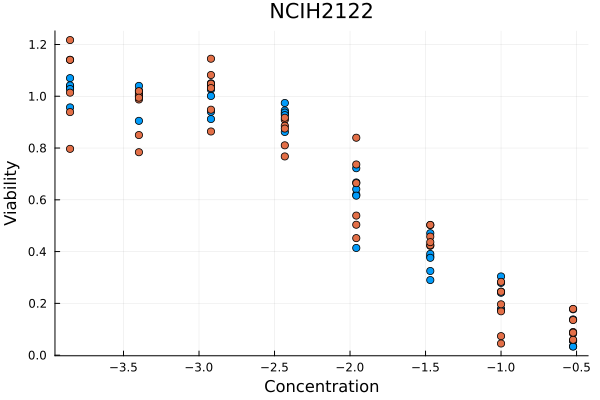

In [13]:
s, θ, σ_m_2, m, l, σ = summarystats(chain_mono)[:,:mean]
λ = 0.005
mean_ys = collect(rand(Normal(h(x, l, s, m), sqrt(σ^2 * (h(x, l, s, m) + λ))))  for x in xs)

# plot
scatter(xs, ys, legend=false, xlabel="Concentration", ylabel="Viability", title="$(cellline)")
scatter!(xs, mean_ys)

Now, let's repeat this for all the cell lines in the dataset and plot the results. For this, we use threading to parallelize the computation and speed things up. 

Let's first check that we have enough thredas available:

In [16]:
Threads.nthreads()

4

Ok, seems fine! Now we can start. Note that we pre-allocate the arrays for storing the results, instead of initializing an empty array and `push!`ing stuff into it as we go along -- this would create race conditions with threading.

In [17]:
Random.seed!(13) 

λ = 0.005

# to store the results 
n_celllines = length(unique(df[:,1]))
plotarray = Array{Plots.Plot{Plots.GRBackend},1}(undef, n_celllines)
chains = Array{Chains, 1}(undef, n_celllines)

Threads.@threads for cellline_ind in 1:n_celllines
    cellline = unique(df[:,1])[cellline_ind]
    # extract data
    curdf = filter(row -> row[:cellline] == cellline, df)
    xs = curdf[:,2]
    ys = curdf[:,3]
    # fit model
    chain_mono = sample(fit_mono(xs, ys), NUTS(), 1000, progress=false, verbose=false)
    # get mean parameters
    s, θ, σ_m_2, m, l, σ = summarystats(chain_mono)[:,:mean]
    mean_ys = collect(rand(Normal(h(x, l, s, m), sqrt(σ^2 * (h(x, l, s, m) + λ))))  for x in xs)
    # plot
    curplot = scatter(xs, ys, legend=false, xlabel="Concentration", ylabel="Viability", title="$(cellline)")
    scatter!(xs, mean_ys)
    plotarray[cellline_ind] = curplot
    chains[cellline_ind] = chain_mono
end

plot(plotarray..., layout=(8,5), size=(1200,1500))

┌ Info: Found initial step size
│   ϵ = 0.45
└ @ Turing.Inference /home/waldir/.julia/packages/Turing/zrPsf/src/inference/hmc.jl:204
┌ Info: Found initial step size
│   ϵ = 0.4
└ @ Turing.Inference /home/waldir/.julia/packages/Turing/zrPsf/src/inference/hmc.jl:204
┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference /home/waldir/.julia/packages/Turing/zrPsf/src/inference/hmc.jl:204
┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference /home/waldir/.julia/packages/Turing/zrPsf/src/inference/hmc.jl:204
┌ Info: Found initial step size
│   ϵ = 0.4
└ @ Turing.Inference /home/waldir/.julia/packages/Turing/zrPsf/src/inference/hmc.jl:204
┌ Info: Found initial step size
│   ϵ = 0.05
└ @ Turing.Inference /home/waldir/.julia/packages/Turing/zrPsf/src/inference/hmc.jl:204
┌ Info: Found initial step size
│   ϵ = 0.05
└ @ Turing.Inference /home/waldir/.julia/packages/Turing/zrPsf/src/inference/hmc.jl:204


┌ Info: Found initial step size
│   ϵ = 0.4
└ @ Turing.Inference /home/waldir/.julia/packages/Turing/zrPsf/src/inference/hmc.jl:204
┌ Info: Found initial step size
│   ϵ = 0.4
└ @ Turing.Inference /home/waldir/.julia/packages/Turing/zrPsf/src/inference/hmc.jl:204
┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference /home/waldir/.julia/packages/Turing/zrPsf/src/inference/hmc.jl:204


┌ Info: Found initial step size
│   ϵ = 0.4
└ @ Turing.Inference /home/waldir/.julia/packages/Turing/zrPsf/src/inference/hmc.jl:204
┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference /home/waldir/.julia/packages/Turing/zrPsf/src/inference/hmc.jl:204
┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference /home/waldir/.julia/packages/Turing/zrPsf/src/inference/hmc.jl:204


┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference /home/waldir/.julia/packages/Turing/zrPsf/src/inference/hmc.jl:204
┌ Info: Found initial step size
│   ϵ = 0.4
└ @ Turing.Inference /home/waldir/.julia/packages/Turing/zrPsf/src/inference/hmc.jl:204
┌ Info: Found initial step size
│   ϵ = 0.4
└ @ Turing.Inference /home/waldir/.julia/packages/Turing/zrPsf/src/inference/hmc.jl:204
┌ Info: Found initial step size
│   ϵ = 0.4
└ @ Turing.Inference /home/waldir/.julia/packages/Turing/zrPsf/src/inference/hmc.jl:204
┌ Info: Found initial step size
│   ϵ = 0.4
└ @ Turing.Inference /home/waldir/.julia/packages/Turing/zrPsf/src/inference/hmc.jl:204


┌ Info: Found initial step size
│   ϵ = 0.4
└ @ Turing.Inference /home/waldir/.julia/packages/Turing/zrPsf/src/inference/hmc.jl:204
┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference /home/waldir/.julia/packages/Turing/zrPsf/src/inference/hmc.jl:204
┌ Info: Found initial step size
│   ϵ = 0.4
└ @ Turing.Inference /home/waldir/.julia/packages/Turing/zrPsf/src/inference/hmc.jl:204
┌ Info: Found initial step size
│   ϵ = 0.4
└ @ Turing.Inference /home/waldir/.julia/packages/Turing/zrPsf/src/inference/hmc.jl:204
┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference /home/waldir/.julia/packages/Turing/zrPsf/src/inference/hmc.jl:204
┌ Info: Found initial step size
│   ϵ = 0.4
└ @ Turing.Inference /home/waldir/.julia/packages/Turing/zrPsf/src/inference/hmc.jl:204
┌ Info: Found initial step size
│   ϵ = 0.4
└ @ Turing.Inference /home/waldir/.julia/packages/Turing/zrPsf/src/inference/hmc.jl:204
┌ Info: Found initial step size
│   ϵ = 0.4
└ @ Turing.Inference /home/waldi

┌ Info: Found initial step size
│   ϵ = 0.4
└ @ Turing.Inference /home/waldir/.julia/packages/Turing/zrPsf/src/inference/hmc.jl:204
┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference /home/waldir/.julia/packages/Turing/zrPsf/src/inference/hmc.jl:204
┌ Info: Found initial step size
│   ϵ = 0.4
└ @ Turing.Inference /home/waldir/.julia/packages/Turing/zrPsf/src/inference/hmc.jl:204
┌ Info: Found initial step size
│   ϵ = 0.4
└ @ Turing.Inference /home/waldir/.julia/packages/Turing/zrPsf/src/inference/hmc.jl:204


┌ Info: Found initial step size
│   ϵ = 0.4
└ @ Turing.Inference /home/waldir/.julia/packages/Turing/zrPsf/src/inference/hmc.jl:204
┌ Info: Found initial step size
│   ϵ = 0.4
└ @ Turing.Inference /home/waldir/.julia/packages/Turing/zrPsf/src/inference/hmc.jl:204
┌ Info: Found initial step size
│   ϵ = 0.05
└ @ Turing.Inference /home/waldir/.julia/packages/Turing/zrPsf/src/inference/hmc.jl:204
┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference /home/waldir/.julia/packages/Turing/zrPsf/src/inference/hmc.jl:204


┌ Info: Found initial step size
│   ϵ = 0.4
└ @ Turing.Inference /home/waldir/.julia/packages/Turing/zrPsf/src/inference/hmc.jl:204
┌ Info: Found initial step size
│   ϵ = 0.4
└ @ Turing.Inference /home/waldir/.julia/packages/Turing/zrPsf/src/inference/hmc.jl:204
┌ Info: Found initial step size
│   ϵ = 0.4
└ @ Turing.Inference /home/waldir/.julia/packages/Turing/zrPsf/src/inference/hmc.jl:204
┌ Info: Found initial step size
│   ϵ = 0.4
└ @ Turing.Inference /home/waldir/.julia/packages/Turing/zrPsf/src/inference/hmc.jl:204
┌ Info: Found initial step size
│   ϵ = 0.4
└ @ Turing.Inference /home/waldir/.julia/packages/Turing/zrPsf/src/inference/hmc.jl:204
